In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
# Helper functions and creating the data
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope):
    return time * slope

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, 
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(season_time * 3))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline=10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series = series + noise(time, noise_level, seed=42)

split = 1000
time_train = time[:split]
x_train = series[:split]
time_valid = time[split:]
x_valid = series[split:]

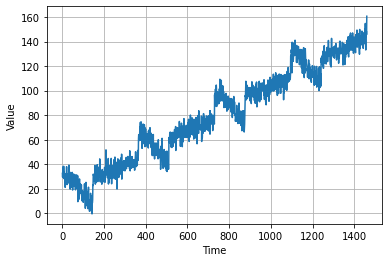

In [14]:
plot_series(time, series)

In [3]:
# Preparing the data
window_size = 20
batch_size = 32
buffer_size = 1000

def window_dataset(series, window_size, buffer_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(buffer_size).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = window_dataset(series, window_size, buffer_size, batch_size)

In [ ]:
# Model

model = tf.keras.Sequential([
                            tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
                            tf.keras.layers.Dense(10, activation="relu"),
                            tf.keras.layers.Dense(1)
])

model.summary()
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100)

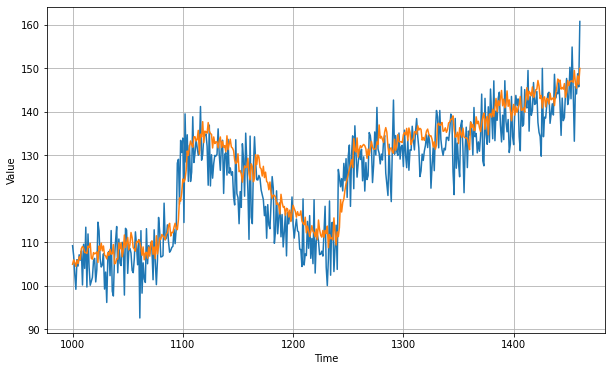

In [5]:
def forecast_series(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    forecast = forecast[split-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results

results = forecast_series(series, window_size)
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.show()

In [6]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

5.0771255


In [ ]:
model = tf.keras.Sequential([
                            tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
                            tf.keras.layers.Dense(10, activation="relu"),
                            tf.keras.layers.Dense(1)
])

# For 20 epochs we increase our learning rate by 10 so within 100 epochs we go from 10-8 to 10-3
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100 ,callbacks=[lr_scheduler])

(1e-08, 0.001, 0.0, 300.0)

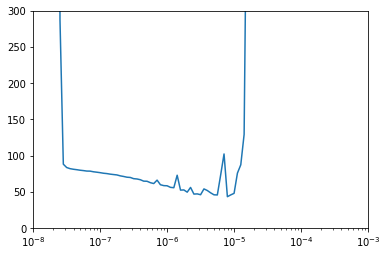

In [8]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

As we can see the learning rate stablizes beteen 10-6 and 10-5 so we will experiment with values in that range.

In [9]:
window_size = 30
dataset = window_dataset(x_train, window_size, batch_size, buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

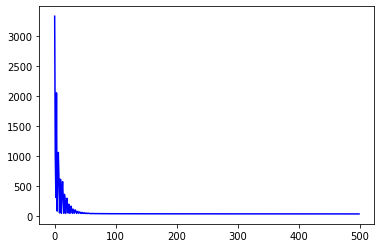

In [10]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

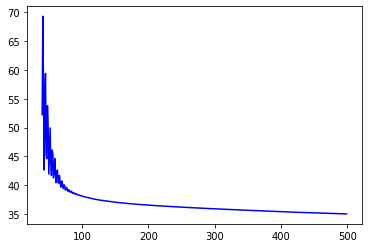

In [11]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(40, len(loss))
plot_loss = loss[40:]
#print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

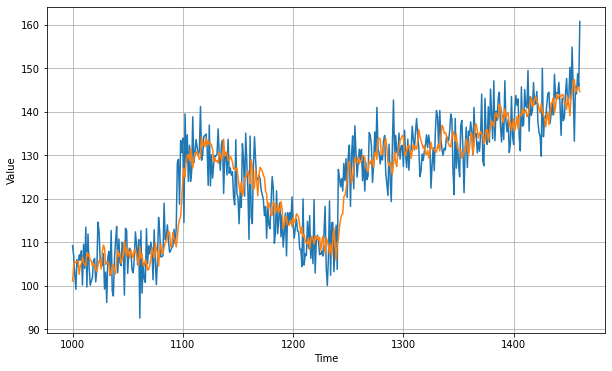

In [12]:
results = forecast_series(series, window_size)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [13]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

4.611305


As you can see we have decreased the MAE by 0.4

## Another series


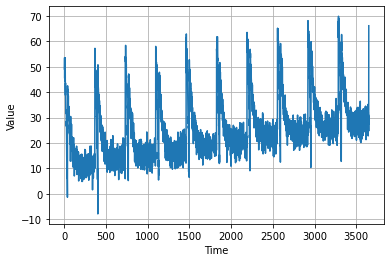

In [15]:
# Helper functions and creating the data
def seasonal_pattern(season_time):
    return np.where(season_time < 0.1, 
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(season_time * 9))

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time, series)

In [16]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = window_dataset(series, window_size, buffer_size, batch_size)

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

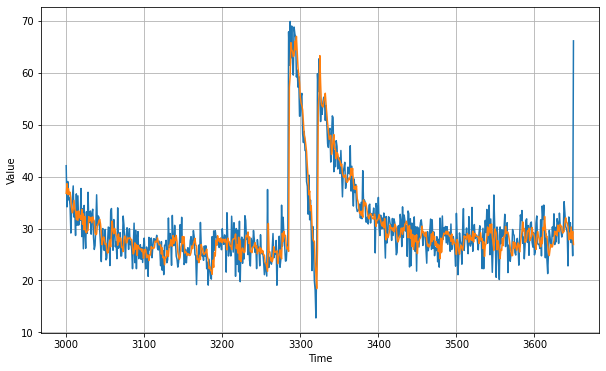

In [18]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.9393656

Good MAE. Acheived.